In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
import zipfile
from PIL import Image

In [2]:
# Define the Generator (U-Net Style)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder: Downsampling layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # First layer: Input channels = 3 (RGB), Output channels = 64
            nn.ReLU(True), # Activation function for non-linearity
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # Second layer: Halves the spatial dimensions
            nn.BatchNorm2d(128), # Batch normalization for stable training and faster convergence
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # Third layer: Further halves the spatial dimension
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        # Decoder: Upsampling layers 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # Upsamples the spatial dimensions by 2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # Second upsampling layer
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Final layer: Restores the original dimensions, 3 channels (RGB)
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Pass input through encoder to extract features
        x = self.encoder(x)
        # Pass the extracted features through decoder to reconstruct the output
        x = self.decoder(x)
        return x

In [3]:
# Define the Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # PatchGAN discriminator model
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True), # LeakyReLU activation to prevent dying neurons
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), # Batch normalization for stable training and faster convergence
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # Further halves spatial dimensions
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True), # Final layer: Outputs a single channel (real or fake prediction)
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        # Forward pass through the PatchGAN model
        return self.model(x)


In [4]:
# Initializing Models
generator = Generator()
discriminator = Discriminator()

# Checking if CUDA (GPU) is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Moving the models to selected device
generator = generator.to(device)
discriminator = discriminator.to(device) #a

# Loss Functions and Optimizers
adversarial_loss = nn.MSELoss()  # for adversarial training
cycle_loss = nn.L1Loss() # L1 loss for cycle consistency
identity_loss = nn.L1Loss() # L1 loss for identity mapping

#Optimizers for Generator and discriminators
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [5]:
# Dataset Preparation
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # Resizing images
    transforms.ToTensor(), # Converting images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalizing pixel values to range [-1, 1]
])

data_path = '/kaggle/input/gan-getting-started/'

photos_path = os.path.join(data_path, 'photo_jpg')
monet_path = os.path.join(data_path, 'monet_jpg')

photo_files = [os.path.join(photos_path, file) for file in os.listdir(photos_path)]
monet_files = [os.path.join(monet_path, file) for file in os.listdir(monet_path)]


In [6]:
# A custom dataset class for loading flat images
class FlatImageDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img
# Datasets for the photos and Monet-style images
photo_dataset = FlatImageDataset(photo_files, transform=data_transforms)
monet_dataset = FlatImageDataset(monet_files, transform=data_transforms)
# Data loaders for the datasets
photo_loader = DataLoader(photo_dataset, batch_size=16, shuffle=True)
monet_loader = DataLoader(monet_dataset, batch_size=2, shuffle=True)

In [7]:
# Training Loop
num_epochs = 30 
for epoch in range(num_epochs):
    for i, (photo_batch, monet_batch) in enumerate(zip(photo_loader, monet_loader)):
        # Move data to device
        real_photos = photo_batch.to(device)
        real_monets = monet_batch.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        # Generating fake Monet images from real photos
        fake_monets = generator(real_photos)
        # Getting discriminator's validity prediction for the fake Monet images
        validity = discriminator(fake_monets)
        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 cycle_loss(generator(fake_monets), real_photos) + \
                 identity_loss(generator(real_photos), real_photos)
        g_loss.backward()
        optimizer_G.step()

        # Training Discriminator and computing discriminator's prediction for real and fake Monet images
        optimizer_D.zero_grad()
        real_validity = discriminator(real_monets)
        fake_validity = discriminator(fake_monets.detach())
        d_loss = (adversarial_loss(real_validity, torch.ones_like(real_validity)) + \
                 adversarial_loss(fake_validity, torch.zeros_like(fake_validity))) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print Progress
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], G_Loss: {g_loss.item()}, D_Loss: {d_loss.item()}")

Epoch [1/30], Batch [0], G_Loss: 1.7712880373001099, D_Loss: 0.42179328203201294
Epoch [1/30], Batch [10], G_Loss: 1.3126922845840454, D_Loss: 0.2967742681503296
Epoch [1/30], Batch [20], G_Loss: 1.0835490226745605, D_Loss: 0.28539174795150757
Epoch [1/30], Batch [30], G_Loss: 1.049896001815796, D_Loss: 0.3300146758556366
Epoch [1/30], Batch [40], G_Loss: 0.8883395195007324, D_Loss: 0.2496626377105713
Epoch [1/30], Batch [50], G_Loss: 0.8880000114440918, D_Loss: 0.27060869336128235
Epoch [1/30], Batch [60], G_Loss: 0.7959609031677246, D_Loss: 0.2957460284233093
Epoch [1/30], Batch [70], G_Loss: 0.7436140775680542, D_Loss: 0.27680063247680664
Epoch [1/30], Batch [80], G_Loss: 0.7789866924285889, D_Loss: 0.28672492504119873
Epoch [1/30], Batch [90], G_Loss: 0.6932122707366943, D_Loss: 0.2173759937286377
Epoch [1/30], Batch [100], G_Loss: 0.6571188569068909, D_Loss: 0.23852957785129547
Epoch [1/30], Batch [110], G_Loss: 0.7386825084686279, D_Loss: 0.31469613313674927
Epoch [1/30], Batch [

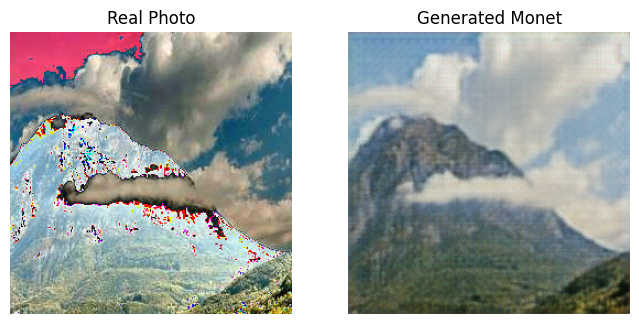

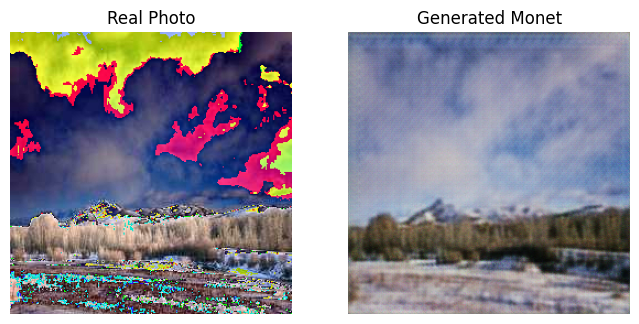

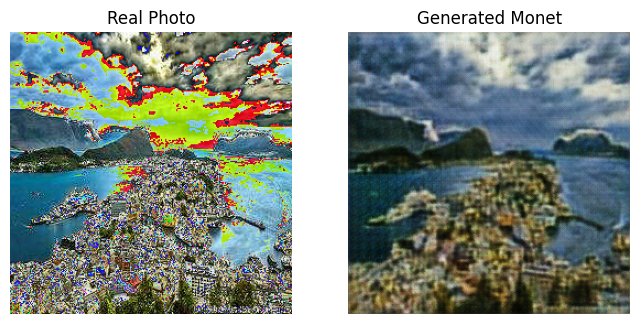

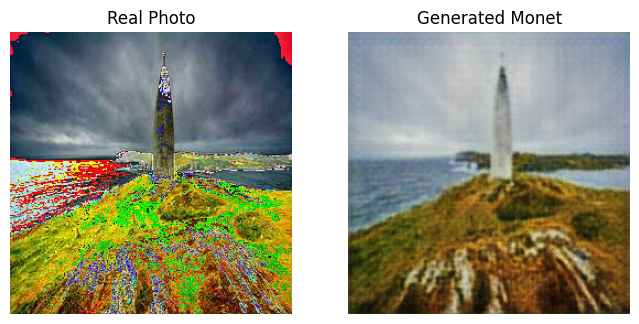

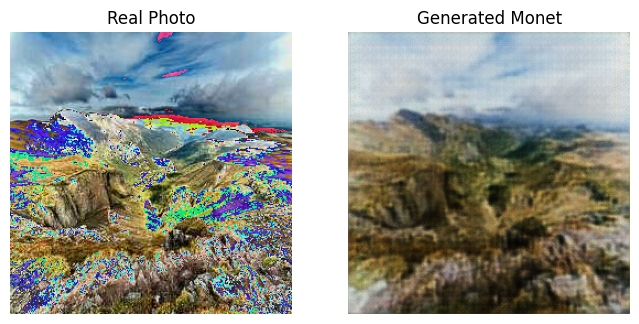

In [8]:
# Visualize Predictions
import matplotlib.pyplot as plt
def visualize_predictions(loader, generator, num_images=5):
    generator.eval()
    with torch.no_grad():
        for i, photo_batch in enumerate(loader):
            real_photos = photo_batch.to(device)
            # Generating Monet-style images from real photos
            fake_monets = generator(real_photos)
            fake_monets = (fake_monets * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0, 1]

            for j in range(min(num_images, len(fake_monets))):
                real_img = transforms.ToPILImage()(real_photos[j].cpu())
                fake_img = transforms.ToPILImage()(fake_monets[j].cpu())

                # Plotting real photo and generated Monet side by side

                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.title("Real Photo")
                plt.imshow(real_img)
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.title("Generated Monet")
                plt.imshow(fake_img)
                plt.axis("off")
                plt.show()

                num_images -= 1
                if num_images <= 0:
                    return

visualize_predictions(photo_loader, generator)


In [9]:
# Generate and Save Images
output_dir = "../tmp/generated_images"
os.makedirs(output_dir, exist_ok=True)
# zip file to store generated images
with zipfile.ZipFile("images.zip", "w") as zipf:
    image_counter = 1  # Initialize a global counter for unique file names
    for i, photo_batch in enumerate(photo_loader):
        real_photos = photo_batch.to(device)
        fake_monets = generator(real_photos)
        fake_monets = (fake_monets * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0, 1]

        for j, img in enumerate(fake_monets):
            img = transforms.ToPILImage()(img.cpu())
            img_path = os.path.join(output_dir, f"image_{image_counter}.jpg")
            img.save(img_path)
            zipf.write(img_path, os.path.basename(img_path))
            image_counter += 1  # Increment the counter for each image

            if image_counter > 8000:  # Stop after generating 8000 images
                break
        if image_counter > 8000:
            break